## 3D Kidney Bilateral Symmetry Analysis

In this section, I will perform **3D registration** of the **Left Kidney** model with its corresponding **Right Kidney** model. The goal of this analysis is to explore the **bilateral symmetry** between the two kidneys by visualizing the alignment and comparing the models based on their **structural similarities**.


In [1]:
import sys
sys.path.append('/Users/antarabhavsar/Desktop/cnsKidney/hra-amap/src')

import trimesh

from organ import Organ
from tissue import TissueBlock
from pipeline import Pipeline
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from steps import normalize_rigid
from utils.conversions import to_array
from copy import deepcopy
import seaborn as sns
import pythreejs as p3
from sklearn.preprocessing import minmax_scale
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Steps : 
1. **Loading the Organ Models:**
   - The **Left Kidney** and **Right Kidney** models are loaded from their respective **GLB files** using the `Organ` class. These 3D models represent anatomical structures that will be aligned for further analysis.

2. **Registration Process:**
   - The **registration pipeline** is applied to both kidneys to align them with the **reference models** (HRA). This process ensures that both models are correctly positioned for comparison.

3. **Visualization:**
   - Using `trimesh`, I visualize the kidney models as **point clouds** in a 3D space. The **Left Kidney** is colored **red**, while the **Right Kidney** is colored **blue** for clarity.
   - The point clouds are overlaid in the same scene to visually inspect their alignment. Adjustments such as scaling and translation are made to ensure the models are correctly positioned and aligned for accurate comparison.

4. **Bilateral Symmetry Analysis:**
   - I compute **Euclidean distances** between corresponding points of the Left and Right Kidneys to quantify the symmetry. These distances are visualized using a **heatmap**, which indicates areas of misalignment, helping to evaluate the registration quality.

5. **Error Analysis:**
   - The signed distances are scaled, and the error is represented using a **color map**. This provides a detailed view of areas where the alignment may require improvement.


In [3]:
left_kidney_path = "/Users/antarabhavsar/Desktop/cnsKidney/hra-amap/data/Kidney/Source/VH_M_Kidney_L.glb"
right_kidney_path = "/Users/antarabhavsar/Desktop/cnsKidney/hra-amap/data/Kidney/Source/VH_M_Kidney_R.glb"
left_kidney_reference = "/Users/antarabhavsar/Desktop/cnsKidney/hra-amap/data/Kidney/Reference/VH_M_Kidney_L.glb"
right_kidney_reference = "/Users/antarabhavsar/Desktop/cnsKidney/hra-amap/data/Kidney/Reference/VH_M_Kidney_R.glb"


In [4]:
left_kidney = Organ(path=left_kidney_path)
right_kidney = Organ(path=right_kidney_path)


In [5]:
left_kidney_ref = Organ(path=left_kidney_reference)
right_kidney_ref = Organ(path=right_kidney_reference)


In [6]:
left_kidney_output = normalize_rigid(source=deepcopy(left_kidney.pointcloud), target=deepcopy(left_kidney_ref.pointcloud))
right_kidney_output = normalize_rigid(source=deepcopy(right_kidney.pointcloud), target=deepcopy(right_kidney_ref.pointcloud))


In [7]:
normalized_left_kidney = to_array(left_kidney_output.output['Source'])
normalized_right_kidney = to_array(right_kidney_output.output['Source'])


In [8]:
left_kidney_pc = trimesh.PointCloud(
    normalized_left_kidney, 
    colors=np.tile(np.array([255, 0, 0, 255]), (len(normalized_left_kidney), 1))  # Red for Left Kidney
)

In [9]:
right_kidney_pc = trimesh.PointCloud(
    normalized_right_kidney, 
    colors=np.tile(np.array([0, 0, 255, 255]), (len(normalized_right_kidney), 1))  # Blue for Right Kidney
)

In [10]:
bilateral_scene = trimesh.Scene([left_kidney_pc, right_kidney_pc])
bilateral_scene.show()

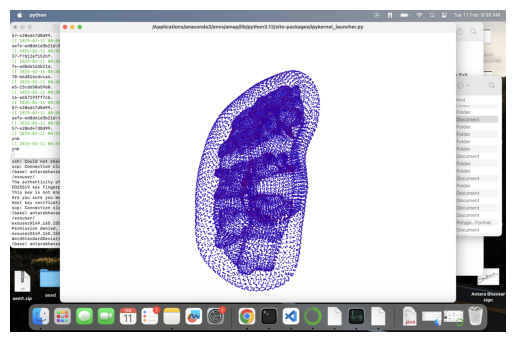

In [11]:


# Load the image
img = mpimg.imread('/Users/antarabhavsar/Desktop/BilateralSymmetry1.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [12]:
distances = np.linalg.norm(normalized_left_kidney - normalized_right_kidney, axis=1)


In [13]:
normalized_distances = distances / np.max(distances)

/var/folders/lh/57sk6w5s1d7bdd5tqmj0tnxr0000gn/T/ipykernel_65646/2484628254.py:1: RuntimeWarning: invalid value encountered in divide
  normalized_distances = distances / np.max(distances)


In [14]:
colors = plt.cm.plasma(normalized_distances)[:, :3] * 255  # Plasma colormap (RGB)


In [15]:
left_kidney_with_error = trimesh.PointCloud(normalized_left_kidney, colors=colors.astype(np.uint8))
right_kidney_with_error = trimesh.PointCloud(normalized_right_kidney, colors=colors.astype(np.uint8))


In [16]:
symmetry_scene = trimesh.Scene([left_kidney_with_error, right_kidney_with_error])
symmetry_scene.show()


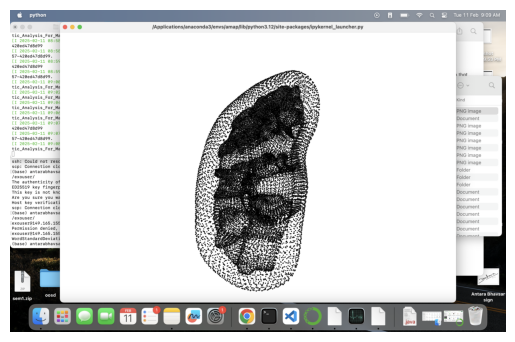

In [19]:
# image_data = symmetry_scene.save_image(resolution=(1080, 1080))
img = mpimg.imread('/Users/antarabhavsar/Desktop/BilateralSymmetry2.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [20]:
pipeline = Pipeline(name='Right Kidney Registration', description='Register Right Kidney Source to Reference', params='../configs/params.yaml')
projections = pipeline.run(source=right_kidney, target=right_kidney_ref)

In [109]:
projected_pc_right = trimesh.PointCloud(
    projections.registration.vertices, 
    colors=np.tile(np.array([255, 0, 0, 255]), (len(projections.registration.vertices), 1))
)
projected_pc_left = trimesh.PointCloud(
    left_kidney.vertices, 
    colors=np.tile(np.array([0, 0, 255, 255]), (len(left_kidney.vertices), 1))
)

bilateral_scene = trimesh.Scene([projected_pc_right, projected_pc_left])

bilateral_scene.show()

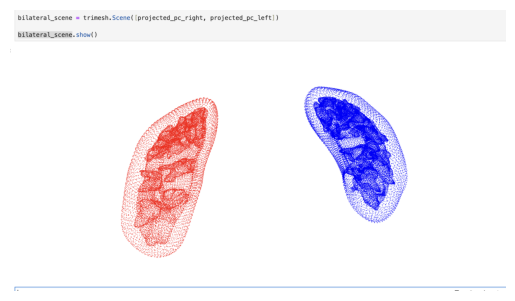

In [2]:
# image_data = symmetry_scene.save_image(resolution=(1080, 1080))
img = mpimg.imread('/Users/antarabhavsar/Desktop/BilateralSymmetry3.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

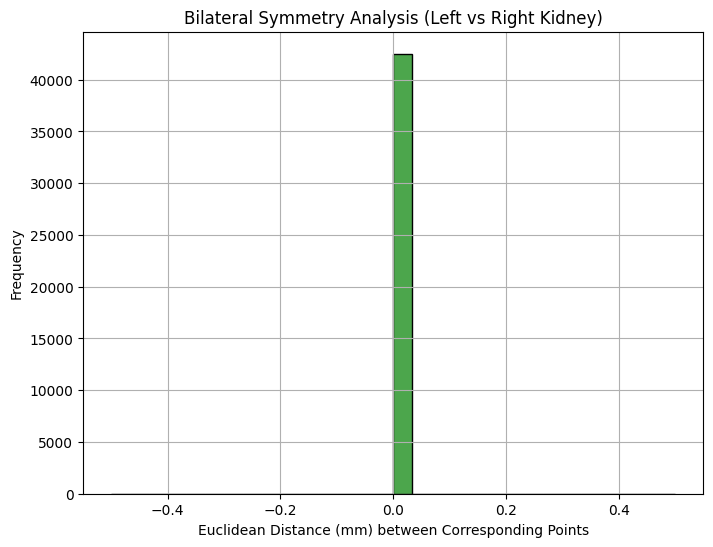

In [58]:
plt.figure(figsize=(8, 6))
sns.histplot(distances, bins=30, color='green', alpha=0.7)
plt.title('Bilateral Symmetry Analysis (Left vs Right Kidney)')
plt.xlabel('Euclidean Distance (mm) between Corresponding Points')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [59]:
distances_scaled = minmax_scale(distances, feature_range=(-1, 1), axis=0)


In [60]:
heatmap_colors = trimesh.visual.interpolate(distances_scaled, color_map='jet')


In [61]:
bilateral_heatmap = trimesh.Trimesh(
    vertices=normalized_left_kidney, 
    faces=left_kidney_ref.faces, 
    vertex_colors=heatmap_colors
)

In [62]:
bilateral_heatmap.show()


### Key Insights:
- The **3D registration** process ensures the Left and Right Kidneys are aligned, allowing for a direct comparison of their anatomical features.
- The **visualization** helps identify misalignments or discrepancies between the models, which is crucial for improving the accuracy of the registration process.
- **Bilateral symmetry analysis** enables us to understand how well the models conform to the expected anatomical symmetry and helps pinpoint areas for further refinement.

### Conclusion:
By performing 3D registration and bilateral symmetry analysis, I gain a deeper understanding of the structural alignment between the Left and Right Kidneys. This approach is valuable in **medical imaging**, where accurate model registration is essential for **diagnostics, surgical planning**, and **research into organ morphology**.